In [ ]:
import pandas as pd
import os

In [ ]:
data = pd.read_csv('Speed Dating Data(clean).csv', delimiter=',')
data

In [ ]:
extracted = data.copy()

extracted= data[['gender', 'int_corr', 'samerace', 'age_o', 'race_o', 'attr_o', 'age', 'race', 'imprace', 'imprelig', 'exphappy', 'dec']]
extracted.to_csv('Extracted_features.csv')
# data.to_csv('Extracted_features.csv')

In [ ]:
print (extracted.iloc[:,:11])

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

train_input = np.genfromtxt('Extracted_features.csv', delimiter = ',')
trainX, trainY = train_input[:,:11],train_input[:,11:12]
(trainX)
(trainY)
trainX_, testX_, trainY_, testY_ = train_test_split(trainX, trainY, test_size=0.3, shuffle=True)

In [ ]:
print('the split train dataX is:', trainX_ ,'and the test dataX is:', testX_)
print('the split train dataY is:', trainY_ ,'and the test dataY is:', testY_)

5703
[   0    1    2 ... 5700 5701 5702]
iter 0: train error nan
iter 0: test error nan
iter 0: training accuracy 0.412765
iter 0: test accuracy 0.439264 

iter 100: train error nan
iter 100: test error nan
iter 100: training accuracy 0.412765
iter 100: test accuracy 0.439264 

iter 200: train error nan
iter 200: test error nan
iter 200: training accuracy 0.412765
iter 200: test accuracy 0.439264 

iter 300: train error nan
iter 300: test error nan
iter 300: training accuracy 0.412765
iter 300: test accuracy 0.439264 

iter 400: train error nan
iter 400: test error nan
iter 400: training accuracy 0.412765
iter 400: test accuracy 0.439264 

iter 500: train error nan
iter 500: test error nan
iter 500: training accuracy 0.412765
iter 500: test accuracy 0.439264 

iter 600: train error nan
iter 600: test error nan
iter 600: training accuracy 0.412765
iter 600: test accuracy 0.439264 

iter 700: train error nan
iter 700: test error nan
iter 700: training accuracy 0.412765
iter 700: test acc

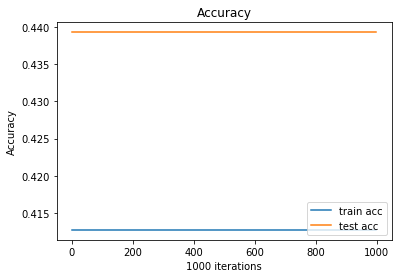

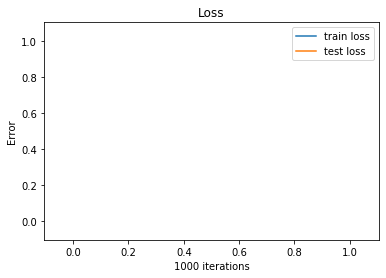

In [2]:
import tensorflow as tf
import numpy as np
import math
import os
import pylab as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')
    
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# scale data
def scale(X, X_min, X_max):
    return (X - X_min) / (X_max - X_min)

NUM_FEATURES = 11
NUM_CLASSES = 2

learning_rate = 0.01
epochs = 1000
batch_size = 32
num_neurons = 10
SEED = 10

np.random.seed(SEED)


def fnn(x, hidden_units):
    # Hidden 1
    h_weights = tf.Variable(
        tf.random.truncated_normal([NUM_FEATURES, hidden_units], stddev=1.0 / math.sqrt(float(NUM_FEATURES))),
        name='weights')
    h_biases = tf.Variable(tf.zeros([hidden_units]), name='biases')

    h = tf.nn.relu(tf.matmul(x, h_weights) + h_biases)

    # Output layer
    weights = tf.Variable(
        tf.random.truncated_normal([hidden_units, NUM_CLASSES], stddev=1.0 / math.sqrt(float(NUM_FEATURES))),
        name='weights')
    biases = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
    logits = tf.matmul(h, weights) + biases

    return logits, h_weights, weights


def main():
    # read train data

    train_input = np.genfromtxt('Extracted_features.csv', delimiter=',')
    trainX, train_Y = train_input[1:, :11], train_input[1:, -1].astype(int)
    trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))

    trainY = np.zeros((train_Y.shape[0], NUM_CLASSES))
    trainY[np.arange(train_Y.shape[0]), train_Y - 1] = 1  # one hot matrix
    
    # split the test and training data into 70:30
    trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.3, shuffle=True)

    n = trainX.shape[0]
    print(n)

    # Create the model
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    logits, h_weights, weights = fnn(x, num_neurons)
#     print(x.shape)
#     print(y_.shape)
    # Build the graph for the deep net

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    beta = tf.constant(1e-6)
    L2_regularization = tf.nn.l2_loss(h_weights) + tf.nn.l2_loss(weights)
    loss = tf.reduce_mean(cross_entropy + beta * L2_regularization)

    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

    correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    
#     print()

    N = len(trainX)
    idx = np.arange(N)
    print(idx)
    converged = False

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_acc = []
        test_acc = []
        train_err = []
        test_err = []

        for i in range(epochs):
            np.random.shuffle(idx)
            trainX_ = trainX[idx]
            trainY_ = trainY[idx]
#             print(trainX_.shape)
#             print(trainY_.shape)
            for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                train_op.run(feed_dict={x: trainX_[start:end], y_: trainY_[start:end]})

            train_acc.append(accuracy.eval(feed_dict={x: trainX_, y_: trainY_}))
            test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
            
            train_err.append(loss.eval(feed_dict={x: trainX_, y_: trainY_}))
            test_err.append(loss.eval(feed_dict={x: testX, y_: testY}))

            if i % 100 == 0:
                print('iter %d: train error %g' % (i, train_err[i]))
                print('iter %d: test error %g' % (i, test_err[i]))
                print('iter %d: training accuracy %g' % (i, train_acc[i]))
                print('iter %d: test accuracy %g' % (i, test_acc[i]), '\n')
            if not converged and i > 100 and test_err[i - 100] - test_err[i] < 0.0001:
                print("converged at iteration ", i)
                converged = True

    # plot learning curves

    plt.figure(1)
    plt.plot(range(epochs), train_acc)
    plt.plot(range(epochs), test_acc)
    plt.legend(["train acc", "test acc"], loc='lower right')
    plt.xlabel(str(epochs) + ' iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.savefig('./figures/Training_Acc.png')

    plt.figure(2)
    plt.plot(range(epochs), train_err)
    plt.plot(range(epochs), test_err)
    plt.legend(["train loss", "test loss"], loc='upper right')
    plt.xlabel(str(epochs) + ' iterations')
    plt.ylabel('Error')
    plt.title('Loss')
    plt.savefig('./figures/Testing_Acc.png')

    plt.show()


if __name__ == '__main__':
    main()

In [ ]:
# extracted = data[['gender', 'match', 'int_corr', 'samerace', 'age_o', 'race_o', 'dec_o', 'attr_o', 'age', 'field_cv', 'race', 'imprace', 'imprelig', 'income', 'career_c', 'exphappy', 'dec']]
# print(extracted)